In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
import stelardatafile as sdf
import matplotlib.pyplot as plt

In [3]:
polymer=sdf.StelarDataFile('297K.sdf',r'data')
polymer.sdfimport()

probably end of file reached
145 experiments read


In [56]:
### preprocessing of the data experiment number ie=1
ie=1
parameters=polymer.getparameter(ie)
bs=int(parameters['BS'])
try:
    nblk=int(parameters['NBLK'])
except:
    nblk=1;
ns=int(parameters['NS'])
try:
    dw=parameters['DW']*1e-6 #dwell time is in [mu s]
except:
    dw=1
temperature=parameters['TEMP']
fid=pd.DataFrame(polymer.getdata(ie),index=np.linspace(dw,dw*bs*nblk,bs*nblk),
                 columns=['real', 'im'])/ns
fid['abs']=( fid['real']**2 + fid['im']**2 )**0.5 # last two lines may represent a seperate method


tau=np.logspace(-3,np.log10(5*parameters['T1MX']),nblk) #as a dummy
startpoint=int(0.05*bs)-1
endpoint=int(0.1*bs)
phi=np.zeros(nblk)
for blk in range(nblk):
    start=startpoint + blk * bs
    end=endpoint + blk * bs
    phi[blk]=fid['abs'].iloc[start:end].sum() / (endpoint-startpoint)

<IPython.core.display.Javascript object>


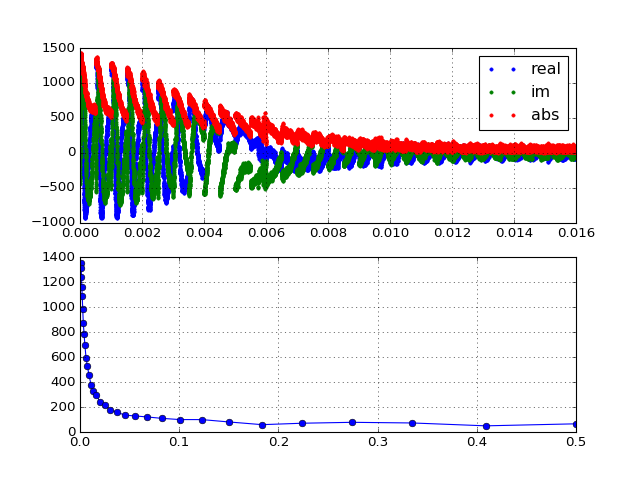

In [5]:
fig, axes = plt.subplots(2)
fid.plot(marker='.',linestyle='none', ax=axes[0])
axes[1].plot(tau,phi, '-o')
for ax in axes:
    ax.grid('on')

# understanding tau:

eval is evil in python... Can be used for injection. see http://stackoverflow.com/questions/2371436/evaluating-a-mathematical-expression-in-a-string
Complicated alternative:

In [60]:
import numpy.matlib
from num_string_eval import NumericStringParser
nsp = NumericStringParser()

T1MX = parameters['T1MX'] # T1MX is used in the 'eval' expressions below
# TODO: not tested yet for all cases
if parameters['BGRD'] == 'LIST':
    temp = parameters['BLST']
    temp.replace(';', ':')
    sep_indices = [pos for pos, char in enumerate(ele) if char == ':'] # find indices of ':'
    Tini = nsp.eval(temp[:sep_indices[0]].replace('T1MX', str(T1MX)))
    Tend = nsp.eval(temp[sep_indices[0]+1:sep_indices[1]].replace('T1MX', str(T1MX)))
    npts = nsp.eval(temp[sep_indices[2]+1:].replace('T1MX', str(T1MX))) # number of points selected: can be ~= NBLK    
    if temp[sep[1]+1:sep[2]] == 'LIN':
        listx = linspace(Tini,Tend,npts);
    elif temp[sep[1]+1:sep[2]] == 'LOG':
        listx = np.logspace(np.log10(Tini),np.log10(Tend),npts);
    nrep = np.ceil(nblk/npts) # find if the time vector needs to be longer
    x = numpy.matlib.repmat(listx,1,nrep) # re-create the time vector
    x = x[:nblk] # select the portion corresponding to the number of blocs (needed if npts~=nblk)
elif parameters['BGRD'] == 'LIN':
    Tini = nsp.eval(parameters['BINI'].replace('T1MX', str(T1MX)))
    Tend = nsp.eval(parameters['BEND'].replace('T1MX', str(T1MX)))
    x = np.linspace(Tini, Tend, nblk) # re-create the time vector
elif parameters['BGRD'] == 'LOG':
    Tini = nsp.eval(parameters['BINI'].replace('T1MX', str(T1MX)))
    Tend = nsp.eval(parameters['BEND'].replace('T1MX', str(T1MX)))
    x = np.logspace(np.log10(Tini),np.log10(Tend),nblk) # re-create the time vector